# SEIZURE CLASSIFICATION

## Data Extraction:

In [ ]:
from wget import download
from os import chdir, getcwd, mkdir, path

In [ ]:
folders = 24
dataset_path = 'test'
base_url = 'https://archive.physionet.org/pn6/chbmit/'    # url that contains CHB-MIT Scalp EEG Database


In [ ]:
list_of_folders = []
for i in range (1, folders+1):
    if i<10:
        name = 'chb0'
    else:
        name = 'chb'
    list_of_folders.append(name + str(i))

In [ ]:
'''
https://stackoverflow.com/questions/1883980/find-the-nth-occurrence-of-substring-in-a-string
'''
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start + len(needle))
        n -= 1
    return start

In [ ]:
initial_path = getcwd()
if not path.exists(dataset_path):
    mkdir(dataset_path)
chdir(dataset_path)


files = []
# for every folder contained in the dataset
for l in list_of_folders:

    # check if the folder already exists, otherwise create it
    if not path.exists(l):
        mkdir(l)
        print('Creation of the directory', l, 'succeeded')
    else:
        print ('Directory', l,  'already exists')

    # change the working directory to the current list's file
    chdir(l)

    # for the current folder, download the 'MD5SUMS' file that enumerates all the files contained in the folder.
    # save the names of the files in a list
    folder_url = base_url + l
    url = folder_url + '/' + 'MD5SUMS'
    print ('Downloading ', url, 'to ', getcwd())
    if not path.isfile('MD5SUMS'):
        download(url)
    else:
        print('File MD5SUMS already exists to ', getcwd())
    f = open('MD5SUMS','r')
    lines = f.readlines()
    f.close()
    # for each folder download all the files that contains
    for line in lines:
        fname = line[line.find('chb'):line.find('\n')].strip()
        url = folder_url + '/' + fname

        # check if we have already downloaded the file
        if not path.isfile(fname) and fname.endswith('.seizures'):
            print ('Downloading ', url[:find_nth(url, '.seizures', 1)], 'to ', getcwd())
            download(url[:find_nth(url, '.seizures', 1)])
            print ('Downloading ', url, 'to ', getcwd())
            download(url)

    # change the working directory to the parent folder
    chdir('..')
chdir(initial_path)

Directory chb01 already exists
File MD5SUMS already exists to  /content/test/chb01
Directory chb02 already exists
File MD5SUMS already exists to  /content/test/chb02
Directory chb03 already exists
File MD5SUMS already exists to  /content/test/chb03
Directory chb04 already exists
File MD5SUMS already exists to  /content/test/chb04
Directory chb05 already exists
File MD5SUMS already exists to  /content/test/chb05
Directory chb06 already exists
File MD5SUMS already exists to  /content/test/chb06
Directory chb07 already exists
File MD5SUMS already exists to  /content/test/chb07
Directory chb08 already exists
File MD5SUMS already exists to  /content/test/chb08
Directory chb09 already exists
File MD5SUMS already exists to  /content/test/chb09
Directory chb10 already exists
File MD5SUMS already exists to  /content/test/chb10
Directory chb11 already exists
File MD5SUMS already exists to  /content/test/chb11
Directory chb12 already exists
File MD5SUMS already exists to  /content/test/chb12
Dire

In [ ]:
!pip install antropy
# Please start by installing those two Python packages
!pip3 install pyedflib
!pip3 install PyWavelets

import pyedflib as edf
import numpy as np
import glob
import pandas as pd
import random
import antropy as ent
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [ ]:
!pip install wfdb

import wfdb
import gc

!pip install mne


import mne
import re
import tqdm
import logging

In [ ]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

In [ ]:
path2pt = '/content/test'

folders = sorted(glob.glob(path2pt+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

print(*n_patient)


01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [ ]:
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)


Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [ ]:
files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [ ]:
len(files_train), len(files_test)


(116, 25)

## Signal Extraction for training data

In [ ]:
mne.set_log_level(verbose='ERROR')


In [ ]:
import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''


"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [ ]:

logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

time_window = 8
time_step = 4

if os.path.exists('/kaggle/input/mit-chb-processed/signal_samples.npy')&os.path.exists('/kaggle/input/mit-chb-processed/is_sz.npy'):
    array_signals=np.load('/kaggle/input/mit-chb-processed/signal_samples.npy')
    array_is_sz=np.load('/kaggle/input/mit-chb-processed/is_sz.npy')
else:
    p = 0.01
    counter = 0
    for temp_f in files_train:
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz = np.zeros((temp_edf.n_times,))
            if os.path.exists(temp_f+'.seizures'):
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            temp_len = temp_edf.n_times

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            counter = counter + temp_0_sample_size + temp_1_sample_size
        temp_edf.close()

    array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
    array_is_sz = np.zeros(counter, dtype=bool)

    counter = 0
    for n, temp_f in enumerate(tqdm.tqdm(files_train)):
        to_log = 'No. {}: Reading. '.format(n)
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
        if n_label_match==len(ch_labels):
            ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
            temp_edf.rename_channels(ch_mapping)
            #temp_edf = temp_edf.pick(ch_labels)

            temp_is_sz = np.zeros((temp_edf.n_times,))
            temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

            if os.path.exists(temp_f+'.seizures'):
                to_log = to_log+'sz exists.'
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            else:
                to_log = to_log+'No sz.'

            temp_len = temp_edf.n_times

            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )
            del temp_is_sz

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            # sz data
            temp_ind = list(np.where(temp_is_sz_ind>0)[0])
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = True
                counter = counter+1

            # no sz data
            temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = False
                counter = counter+1

            to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
                temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
            )

        else:
            to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)

        logger.info(to_log)
        temp_edf.close()

        if n%10==0:
            gc.collect()
    gc.collect()

    np.save('signal_samples', array_signals)
    np.save('is_sz', array_is_sz)

100%|██████████| 116/116 [02:19<00:00,  1.20s/it]


In [ ]:
array_signals.shape

(3913, 18, 2048)

## Data Preprocessing:

In [ ]:
array_signals = array_signals[:, :, ::2]

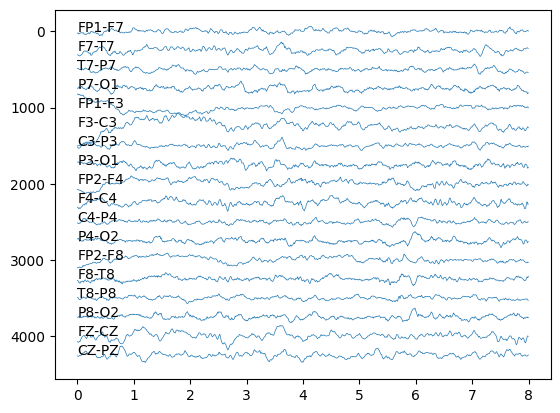

In [ ]:
# show a sample of extracted signals (the last one)

vertical_width = 250
signals = array_signals[-1, :, :]
fs = 128

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [ ]:
# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))


Number of all the extracted signals: 3913
Number of signals with seizures: 2581
Ratio of signals with seizures: 0.660


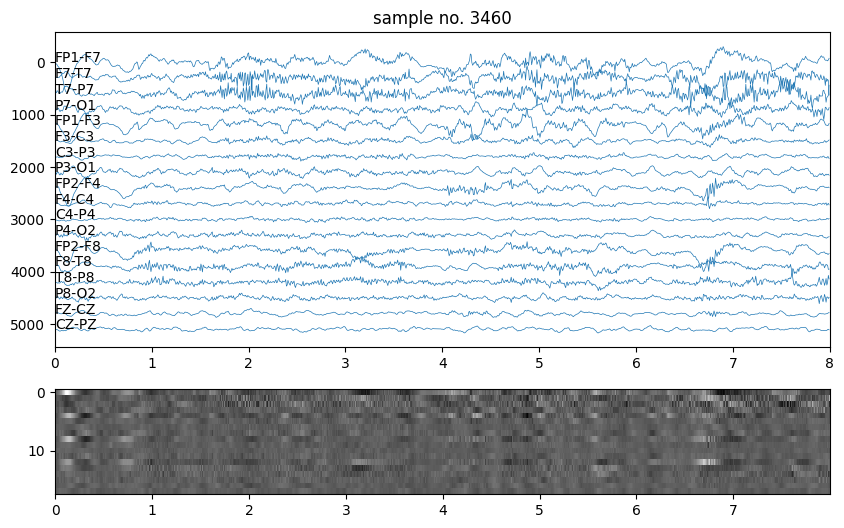

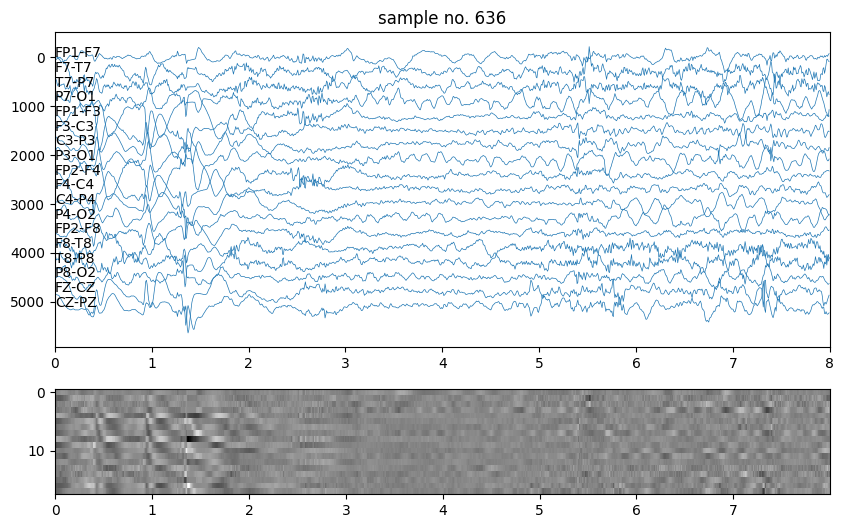

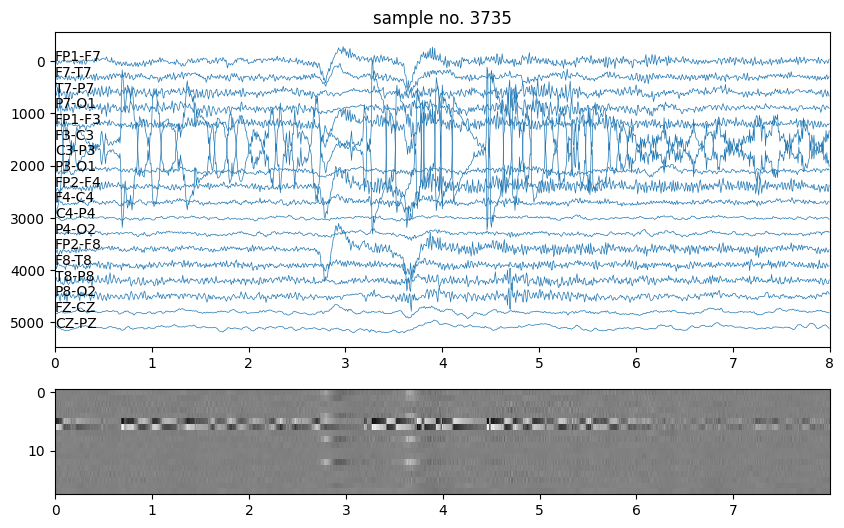

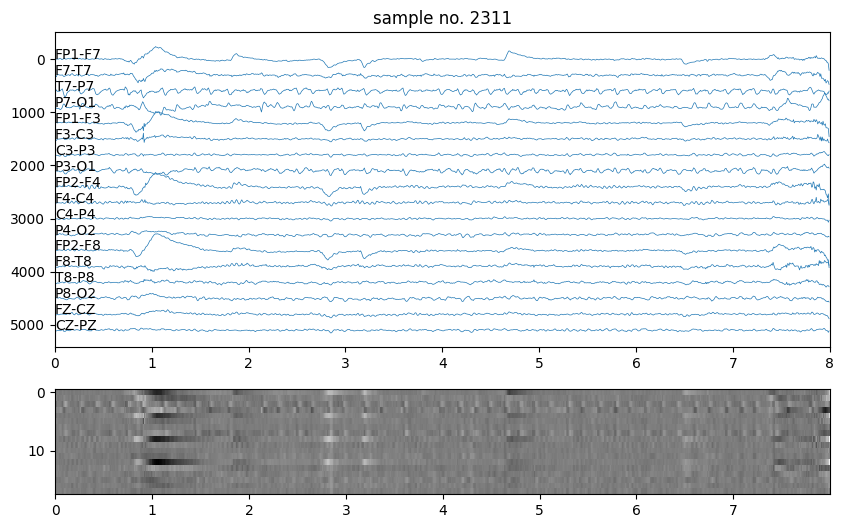

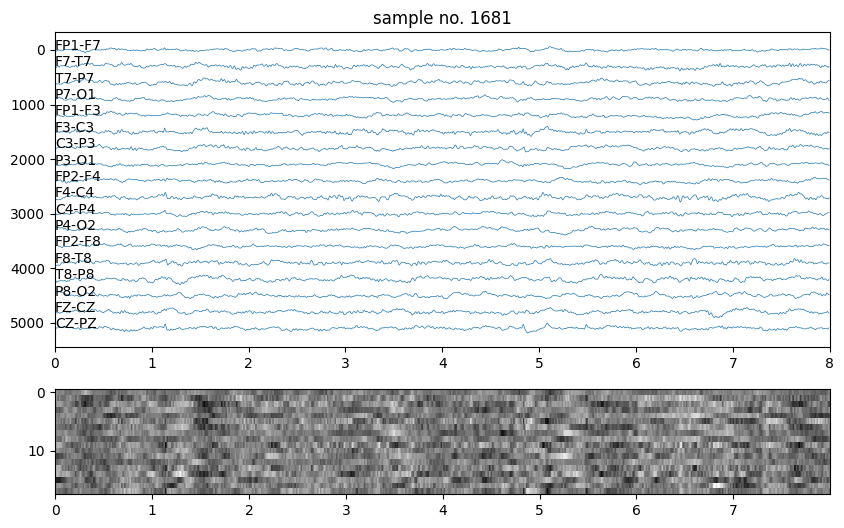

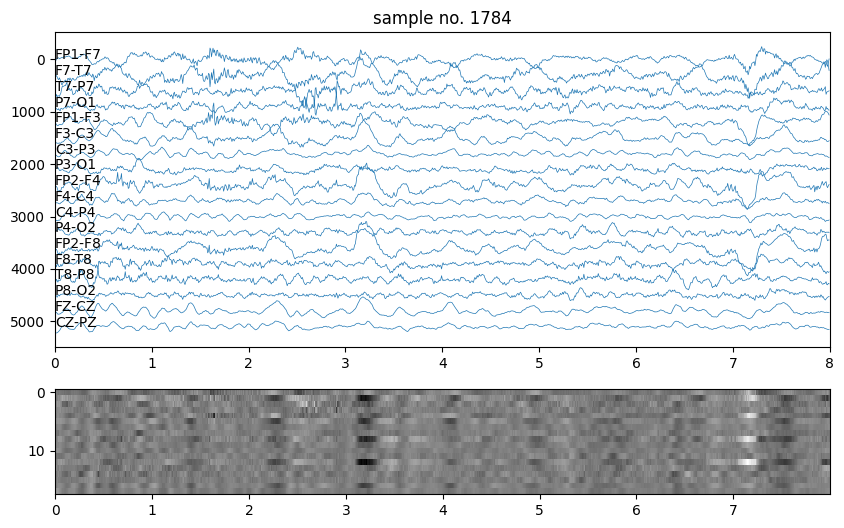

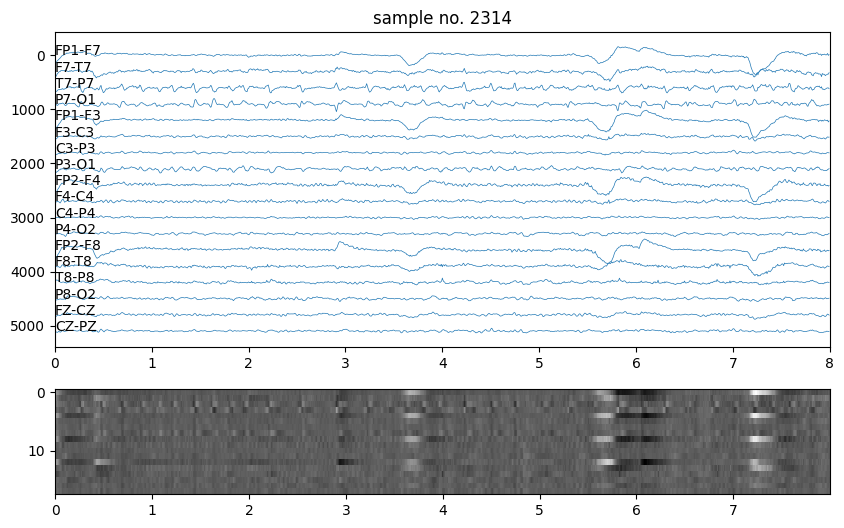

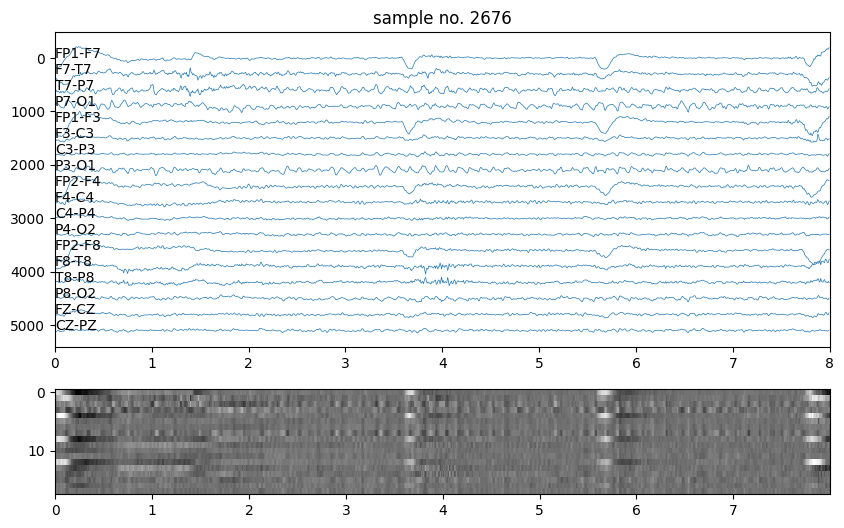

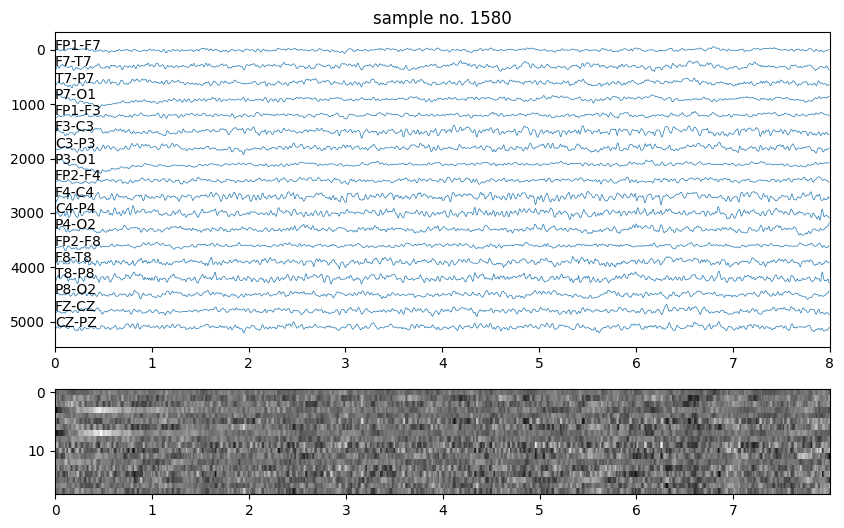

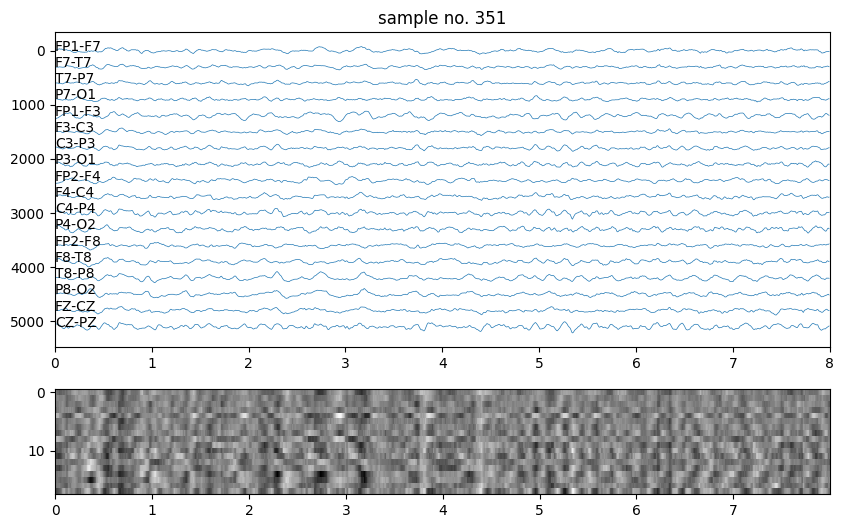

In [ ]:
# Let's see samples with seizures.

for n in random.sample(list(array_n), 10):

    vertical_width = 300
    temp_signals = array_signals[n, :, :]
    fs = 128

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1])/fs, temp_signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i*vertical_width))
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title('sample no. {}'.format(n))

    ax[1].pcolormesh(np.arange(temp_signals.shape[-1])/fs, np.arange(len(ch_labels)), temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()

    plt.show()

In [ ]:
from sklearn import model_selection

In [ ]:
array_signals = array_signals[:, :, :, np.newaxis]

array_signals.shape

(3913, 18, 1024, 1)

In [ ]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(
    array_signals, array_is_sz, test_size=0.3,
    stratify=(array_is_sz>0))

del array_signals, array_is_sz

## Building and training deep learning models with Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
model = keras.models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 1024, 64)      576       
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 512, 64)       32832     
                                                                 
 max_pooling2d (MaxPooling2  (None, 18, 256, 64)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 256, 128)      65664     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 128, 128)      131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 64, 128)        0         
 g2D)                                                   

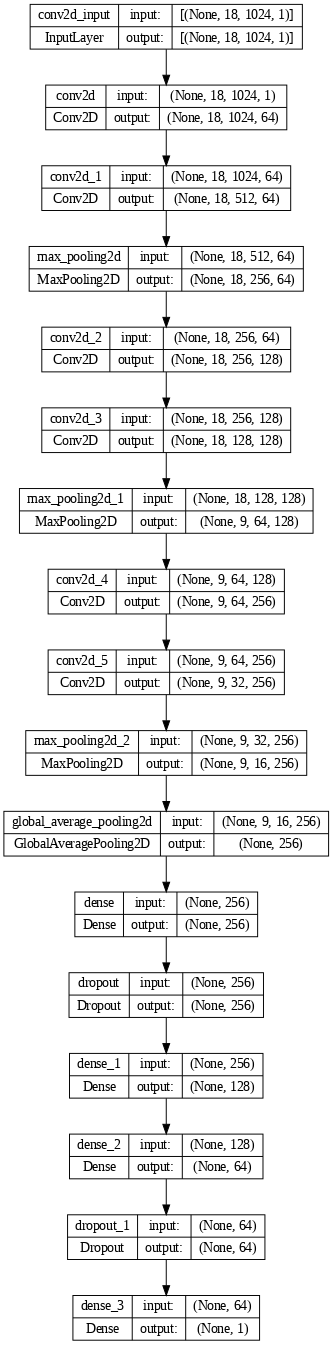

In [ ]:
from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='model.png')
plot_model(model, show_shapes=True, dpi=70)

## Model Training:

In [ ]:
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# callbacks
VERBOSE=1
#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2739, 18, 1024, 1), (2739,), (1174, 18, 1024, 1), (1174,))

In [ ]:
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=6,
    batch_size=256,
    callbacks=callbacks
)

In [ ]:
model.save('CHB_MIT_sz_detec_demo.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


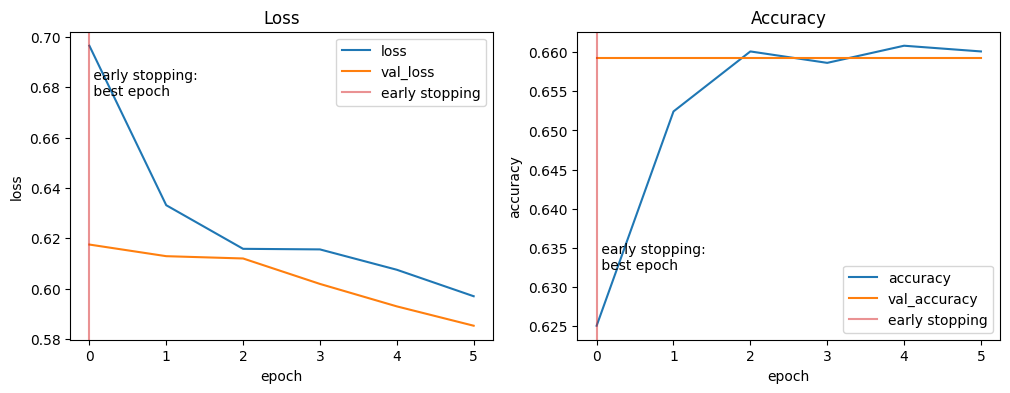

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

## Evaluating the model 

In [ ]:
def sampling_data_pred(f, verbose=True):
    list_signals = []
    list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        #else:
            #print('No sz.', end=' ')

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [ ]:
# reading files and prediction

list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]

    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

100%|██████████| 25/25 [46:49<00:00, 112.36s/it]


In [ ]:
from sklearn import metrics

In [ ]:
# threshold = 0.5
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00     33250
        True       0.02      1.00      0.04       629

    accuracy                           0.02     33879
   macro avg       0.01      0.50      0.02     33879
weighted avg       0.00      0.02      0.00     33879



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# threshold = 0.9
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
print(report)

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     33250
        True       0.21      0.09      0.13       629

    accuracy                           0.98     33879
   macro avg       0.59      0.54      0.56     33879
weighted avg       0.97      0.98      0.97     33879



In [ ]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))

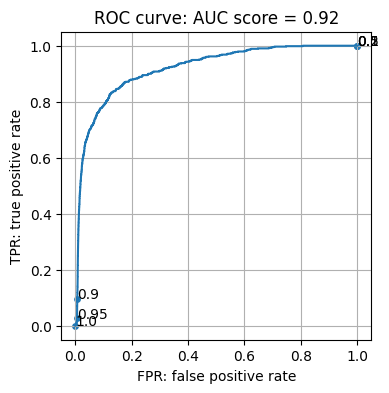

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

## HyperParameter Tuning:

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

# Function to create the MLP model
def create_model(hidden_layer_sizes, alpha, learning_rate_init):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, learning_rate_init=learning_rate_init, max_iter=6)

    return model

# Define the hyperparameter search space
param_dist = {
    'hidden_layer_sizes': [(100,), (200,), (300,)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

# Wrap the model creation function
model = MLPClassifier(max_iter=6)  # You can adjust max_iter based on your needs

# Create a random search object
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)

# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Rest of your code remains the same
# ...

# Fit the random search to your data
random_search.fit(X_train_reshaped, y_train)


# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(200,), learning_rate_init=0.01; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(200,), learning_rate_init=0.01; total time=  14.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(200,), learning_rate_init=0.01; total time=  14.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=  16.6s
[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=  14.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.0001; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.0001; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.0001; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=  13.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   7.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=  12.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.01; total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.01; total time=   6.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.01; total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=  11.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   9.6s
Best Hyperparameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (200,), 'alpha': 0.001}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (200,), 'alpha': 0.001}


## Seizure detection using the deep learning model:

In [ ]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

Index = 0 has seizures: /content/test/chb01/chb01_15.edf
Index = 1 has seizures: /content/test/chb01/chb01_04.edf
Index = 2 has seizures: /content/test/chb01/chb01_26.edf
Index = 3 has seizures: /content/test/chb01/chb01_03.edf
Index = 4 has seizures: /content/test/chb01/chb01_18.edf
Index = 5 has seizures: /content/test/chb01/chb01_21.edf
Index = 6 has seizures: /content/test/chb01/chb01_16.edf
Index = 7 has seizures: /content/test/chb07/chb07_12.edf
Index = 8 has seizures: /content/test/chb07/chb07_13.edf
Index = 9 has seizures: /content/test/chb07/chb07_19.edf
Index = 10 has seizures: /content/test/chb08/chb08_13.edf
Index = 11 has seizures: /content/test/chb08/chb08_05.edf
Index = 12 has seizures: /content/test/chb08/chb08_21.edf
Index = 13 has seizures: /content/test/chb08/chb08_02.edf
Index = 14 has seizures: /content/test/chb08/chb08_11.edf
Index = 15 has seizures: /content/test/chb10/chb10_31.edf
Index = 16 has seizures: /content/test/chb10/chb10_89.edf
Index = 17 has seizures:

In [ ]:
def moving_ave(a, n):
    if len(a.shape)!=1:
        print('Not 1 dimension array. return nothing.')
        return
    temp = np.zeros(a.size-n)
    for i in range(n):
        temp = temp+a[i:-n+i]
    temp = temp/n

    return temp

In [ ]:
# get signals and labels from test data.
n=20
array_signals, array_is_sz = sampling_data_pred(files_test[n])

# preprocess
array_signals=array_signals[:, :, ::2, np.newaxis]

# use deep learning model
pred = model.predict(array_signals)

/content/test/chb10/chb10_12.edf: Reading. 
57/57 [==============================] - 133s 2s/step


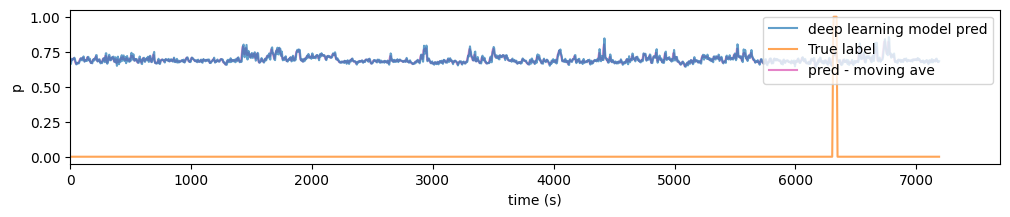

In [ ]:
time_window = 8
time_step = 4
mv_win = 3

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(pred.size)*time_step, pred.flatten(), alpha=0.7, label='deep learning model pred')
ax.plot(np.arange(pred.size)*time_step, array_is_sz, alpha=.7, label='True label')

pred_moving_ave = moving_ave(pred.flatten(), mv_win)
pred_peaks, _ = find_peaks(pred_moving_ave, height=.95, distance=6)
ax.plot(np.arange(pred.size-mv_win)*time_step, pred_moving_ave,
        alpha=.9, label='pred - moving ave', color='tab:pink', zorder=0)
ax.scatter(pred_peaks*time_step, pred_moving_ave[pred_peaks], s=20, color='tab:red')

ax.set_xlabel('time (s)')
ax.set_ylabel('p')
ax.set_xlim(0, pred.size*time_step+500)
ax.legend(loc='upper right')
plt.show()

# Model Testing

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have already reshaped your data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

# Create an instance of MLPClassifier with the best hyperparameters from your search
best_params = {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'alpha': 0.0001}
model = MLPClassifier(max_iter=15, **best_params)

# Train the model
model.fit(X_train_reshaped, y_train)

# Make predictions on the validation set
y_val_pred = model.predict(X_val_reshaped)

# Evaluate the accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)


Validation Accuracy: 0.9609028960817717


In [ ]:
from sklearn.metrics import f1_score

# Make predictions on the training set
y_val_pred = model.predict(X_val_reshaped)

# Compute the F1 score for the training set
f1_test = f1_score(y_val, y_val_pred)
print("Training F1 Score:", f1_test)

Training F1 Score: 0.9712945590994371
